In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
import matplotlib.colors as colours
import math
import numpy as np
import os.path
from itertools import cycle
import string
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

plt.rcParams["font.family"] = "Times New Roman"
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [21]:
n_measurements = 20 #no. of different values used for each param in the phase diagram
max_gRate = 0.083
g = max_gRate
K = 10000 # this is the K value used in the heatmap sims, K is usually 1000
#K_big = 10000 # this is the K value used in the heatmap sims

immigration_ratio = 0.8 # this is r_im/Kg
r_imm = immigration_ratio*K*g # this is the actual numerical value of the immigration rate

#when deterioration greater than this value we change from immigration dominated to deterioration dominated
# phase2_lim = immigration_rate/K 
# phase2_lim_scaled = phase2_lim/max_gRate

N_thresh_min = 0. #range of values for N*
N_thresh_max = 1.5
delta_N_thresh = (N_thresh_max - N_thresh_min)/n_measurements

det_ratio_min = 0. #range of values for deterioration ratio
det_ratio_max = 1.5
delta_det_ratio = (det_ratio_max - det_ratio_min)/n_measurements

#det_ratio_vals_scaled = np.linspace(det_ratio_min, det_ratio_max*((K*max_gRate**2)/immigration_rate), 101)
det_ratio_vals = np.linspace(det_ratio_min, det_ratio_max, 101)

#collection of the parameter pairs used in the histograms of the time to 1st microhab
# commented out b2 and s2 as we didn't use them for the big rep runs
# format is (N*/K, r_det/g)
# histogram_param_pairs = [(1.35,  0.6),
#                          #(1.20,  0.675),
#                          (0.825, 1.2),
#                          #(0.75,  1.35),
#                          (0.6,   0.3),
#                          (0.45,  1.2)]
histogram_param_pairs = [(1.050, 0.750 ),
                         #(1.20,  0.675),
                         (0.825, 1.2),
                         #(0.75,  1.35),
                         (0.6,   0.3),
                         (0.45,  1.2)]


# histogram_param_pairs_scaled = [(n_k, r_det*(K*max_gRate**2)/immigration_rate) for n_k, r_det in histogram_param_pairs]

# these are used to highlight the phase diagram squares used in the stochastic/deterministic comparison plots
# (modified to be close to the ones used in the phase diagram)
# first pair is deterministic, second deterministic
additional_param_pairs = [(0.675, 0.525),
                          (1.2, 0.525)]


histogram_param_pair_labels = ["a", 
                               "b", 
                               "c", 
                               "d"]



histogram_param_pairs = histogram_param_pairs #+ additional_param_pairs
histogram_param_pair_labels = histogram_param_pair_labels #+ additional_param_pair_labels

histogram_param_pair_list = [(pp[0], pp[1], l) for pp, l in zip(histogram_param_pairs, histogram_param_pair_labels)]

In [22]:
df_list = [] #empty list to hold all the dataframes
#iterate through all the seperate csv files and append them to the list
for n in range(n_measurements+1):
    for d in range(n_measurements+1):
        n_thresh = N_thresh_min + n*(delta_N_thresh)
        det_ratio = det_ratio_min + d*(delta_det_ratio)
        
        n_thresh_str = "{:.3f}".format(n_thresh)
        det_ratio_str = "{:.3f}".format(det_ratio)
        
        df = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK_v2/mhLim-1_N^-"+n_thresh_str+"_rDet-"+det_ratio_str+".csv")
        df['time_to_n_raw'] = df['time_to_n']
        df['time_to_n'] = df['time_to_n']*max_gRate
        
        averaged_df = pd.DataFrame(df.mean().to_dict(),index=[df.index.values[-1]])
        averaged_df["time_to_n_stDev"] = df["time_to_n"].std()
        averaged_df["coeff_variation"] = df["time_to_n"].std()/df["time_to_n"].mean() if df["time_to_n"].mean() > 0 else None

        df_list.append(averaged_df)
        
#add all the dataframes together, this is the final dataframe with all the data for the phase diagram
param_data = pd.concat(df_list, ignore_index=True)

In [23]:
# rescale the time_to_n column
param_data['tN_adjusted'] = param_data["time_to_n"]
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0. # this means the population immediately reached the limit in the first interval?
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None # the population never reached the limit during the simulations

# these aren't really used here any more
# param_data['tN_stDev_adjusted'] = param_data["time_to_n_stDev"]
# param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0.
# param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None
# param_data['stochasticity'] = param_data['tN_stDev_adjusted']
# param_data['stochasticity'][(param_data['stochasticity'] > 0.) & param_data['stochasticity']] = param_data['tN_stDev_adjusted']/param_data['tN_adjusted']

In [24]:
# currently the det_ratio column is in terms of column_value = r_det/g, we want to rescale it to r_det*K/r_imm
# we already worked out the true numerical value of the immigration rate above, so we can rescale as
r_det_scaling_factor = (g*K/r_imm)
param_data['r_det_K_r_imm_ratio'] = param_data['det_ratio']*r_det_scaling_factor

# also rescale the param pair values for the highlighted squares
histogram_param_pairs_scaled = [(n_k, r_det*r_det_scaling_factor) for n_k, r_det in histogram_param_pairs]
histogram_param_pair_list_scaled = [(pp[0], pp[1], l) for pp, l in zip(histogram_param_pairs_scaled, histogram_param_pair_labels)]

# used to plot the theory vals
det_ratio_vals_scaled = np.linspace(param_data['r_det_K_r_imm_ratio'].min(), param_data['r_det_K_r_imm_ratio'].max(), 101)

In [25]:
# this is the pivot table used to make the heatmap. n_thresh is already scaled in N/K
pivot = param_data.pivot(index='n_thresh', columns='r_det_K_r_imm_ratio', values='tN_adjusted')

# used to rescale imshow to the numerical ranges
extent = [param_data['r_det_K_r_imm_ratio'].min(), param_data['r_det_K_r_imm_ratio'].max(), param_data['n_thresh'].min(), param_data['n_thresh'].max()]

# create the mask used to highlight the histogram parameter pairs
masko_full = np.zeros_like(pivot)
for pp, label in zip(histogram_param_pairs_scaled, histogram_param_pair_labels):
    n_thresh, r_det = pp
    #pivot.keys() returns the values of r_det with floating point errors
    #following lines get the keys that are used in pivot
    r_det_key = (pivot.keys()[np.isclose(pivot.keys(), r_det)])[0]
    n_thresh_key = (pivot[r_det_key].keys()[np.isclose(pivot[r_det_key].keys(), n_thresh)])[0]

    r_det_key_index = np.where(np.isclose(pivot.keys(), r_det))[0][0]

    n_thresh_key_index = np.where(np.isclose(pivot[pivot.keys()[r_det_key_index]], n_thresh))

    masko = np.isclose(pivot, pivot[r_det_key][n_thresh_key])
    masko_full += masko

pivot_masked = np.ma.masked_where(masko_full, pivot)

In [26]:
def phase_diag_line_v2(r_det_K_r_imm_ratio):
    '''
    Here the x values have already been rescaled to be the true numerical values of r_det*K/r_imm
    '''
    #K = K_big
    i = r_imm
    g = max_gRate
    d = r_det_K_r_imm_ratio*(r_imm/K)
    
    
    NpgK = K*(1-d/g)*(0.5+0.5*np.sqrt(1+(4*i/g/K)/(1-d/g)**2))
    Nmgk = K*(1-d/g)*(0.5-0.5*np.sqrt(1+(4*i/g/K)/(1-d/g)**2))

    NFP = np.max([NpgK, Nmgk])
    
    return NFP/K



def annotate_param_pair(x, y, label, ax=None, **kwargs):
    
    r_det_key_index = np.where(np.isclose(pivot.keys(), x))[0][0]

    n_thresh_key_index = np.where(np.isclose(pivot[pivot.keys()[r_det_key_index]].index, y))[0][0]

    if label in ['a', 'b']: color = 'w'
    else: color = 'k'
        
    if label in ['b', 'd']: y_adjust = 0.005
    else: y_adjust = 0.01
    
    x_index_frac = r_det_key_index/pivot.keys().size + 0.01
    y_index_frac = n_thresh_key_index/pivot.keys().size + y_adjust
    
    ax.annotate(label, (x_index_frac, y_index_frac), color=color, xycoords='axes fraction', **kwargs)

In [30]:
def plotPhaseDiagramAndHistograms(param_pairs, param_pair_labels):
    '''
    This method will combine the t1 phase diagram and the 4 histograms of the selected parameter pairs.
    Have the heatmap in the middle and the 4 histograms on the outside, 2 on left and 2 on right.
    Can use gridspec for this.
    
    param_pairs
    '''
    fig = plt.figure(dpi=320)
    fig.set_size_inches(8, 3.7)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12

    gs = fig.add_gridspec(100, 100, wspace=0.6, hspace=0.34)
    
    ax_b1 = fig.add_subplot(gs[:42, 0:19]) #histogram of b1
    ax_r1 = fig.add_subplot(gs[58:, 0:19]) #histogram of r1
    ax_hm = fig.add_subplot(gs[:, 26:-21]) #heatmap of t1
    ax_s1 = fig.add_subplot(gs[:42, -19:]) #histogram of s1
    ax_r2 = fig.add_subplot(gs[58:, -19:]) #histogram of r2
    
    histogram_axes = [ax_b1, ax_s1, ax_r1, ax_r2]
    letters = list(string.ascii_lowercase)[:len(param_pairs)]
    nbins = 17
    
    #PLOTTING THE 4 HISTOGRAMS ON THE OUTSIDE
#     i = 0
#     for ax, param_pair, title, letter in zip(histogram_axes, param_pairs, histogram_param_pair_labels, letters):
        
#         n_thresh, r_det = param_pair
#         extra_N_vs_t_runs = (math.isclose(n_thresh, 0.825) and math.isclose(r_det, 1.2)) or (math.isclose(n_thresh, 0.6) and math.isclose(r_det, 0.3))
        
#         t1_df = getT1HistoDataAndProcess(n_thresh, r_det, extra_N_vs_t_runs, reps500=True)
        
#         t1_df = t1_df[t1_df["t_scaled"] <= 83]
        
#         # print coefficients of variation
#         print(f'CV ({letter}): {t1_df["t_scaled"].std()/t1_df["t_scaled"].mean()}')

#         ax.hist(t1_df["t_scaled"], bins=nbins)
#         #print(t1_df["t_scaled"][t1_df["t_scaled"]>83])
#         #add insets to the first two plots
#         if i < 2 :
#             ax_ins = inset_axes(ax, width="50%", height="50%")
#             ax_ins.hist(t1_df["t_scaled"], bins=nbins)
#             ax_ins.set_yscale("log", nonposy='clip')
#             #ax_ins.set_ylabel("log(N)", fontsize=9, labelpad=-2)
#             #ax_ins.set_xlabel("tg", fontsize=9, labelpad=-4)
#             ax_ins.set_xticklabels([])
#             ax_ins.set_yticklabels([])
#             ax_ins.spines['right'].set_visible(False)
#             ax_ins.spines['top'].set_visible(False)

#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.set_xlabel("gt", fontsize=16, labelpad=-2)
#         ax.set_yticklabels([])
#         #ax.set_ylabel("N", fontsize=16, labelpad=-2)
#         ax.set_title("("+title+")", pad=-2, fontsize=16)
#         ax.tick_params(axis='both', which='major', labelsize=12, pad=0)
        
#         if i < 2: ax.set_xlabel("")
#         i +=1
        
    #PLOT THE HEATMAP
    ax_hm.spines['top'].set_visible(False)
    ax_hm.spines['right'].set_visible(False)
    
    # remove the white part of the ocean_r colourmap
    min_val, max_val = 0.04,1.0
    n = 256
    orig_cmap = plt.cm.ocean_r
    colors = orig_cmap(np.linspace(min_val, max_val, n))
    cmap = colours.LinearSegmentedColormap.from_list("mycmap", colors)


    ax_hm.imshow(pivot, origin='lower', cmap='Oranges', vmax=3, aspect='auto',
               extent=extent) # plot the unmasked one first, these squares will shine through when we then plot the masked one.
    im = ax_hm.imshow(pivot_masked, origin='lower', cmap=cmap, vmax=3, aspect='auto',
               extent=extent)

    cbar = fig.colorbar(im, pad=0.02, ax=ax_hm)
    cbar.ax.tick_params(labelsize=12, pad=0.8)
    tick_vals = [0., 1., 2., 3.]
    cbar.set_ticks(tick_vals)
    tick_labels = [str(t) for t in tick_vals]
    tick_labels[-1] = ">"+tick_labels[-1]
    cbar.set_ticklabels(tick_labels)
    cbar.set_label("$t_1$ (gt)", fontsize=16, labelpad=-16)

    # PLOT THE THEORY VALS
    theoryN_vals = np.vectorize(phase_diag_line_v2)(det_ratio_vals_scaled)
    ax_hm.plot(det_ratio_vals_scaled, theoryN_vals, linewidth=2.5, color='#e600ac', ls='--')# color="#e60073")

    # ANNOTATE THE SQUARES
    for n_thresh, r_det_ratio, label in histogram_param_pair_list_scaled:
        annotate_param_pair(r_det_ratio, n_thresh, label, ax=ax_hm, fontsize=12)

    #ax_hm.axis('tight')
    ax_hm.set_ylim(0, param_data['n_thresh'].max())
    ax_hm.set_xlabel('r$_{det}K/r_{im}$', fontsize=16, labelpad=0) # change the label as we rescaled it 
    ax_hm.set_ylabel('N*/K', fontsize=16, labelpad=-2)
    ax_hm.xaxis.set_tick_params(labelsize=12.7)
    ax_hm.yaxis.set_tick_params(labelsize=12.7)
    ax_hm.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax_hm.tick_params(axis='both', which='major', pad=2)
    #ax_hm.xaxis.set_major_locator(plt.MaxNLocator(5))
    
    
    #fig.tight_layout()
    plt.savefig("paper_plots_v2/heatmap_and_histograms_v2.pdf", bbox_inches="tight", dpi=420)
    plt.show()

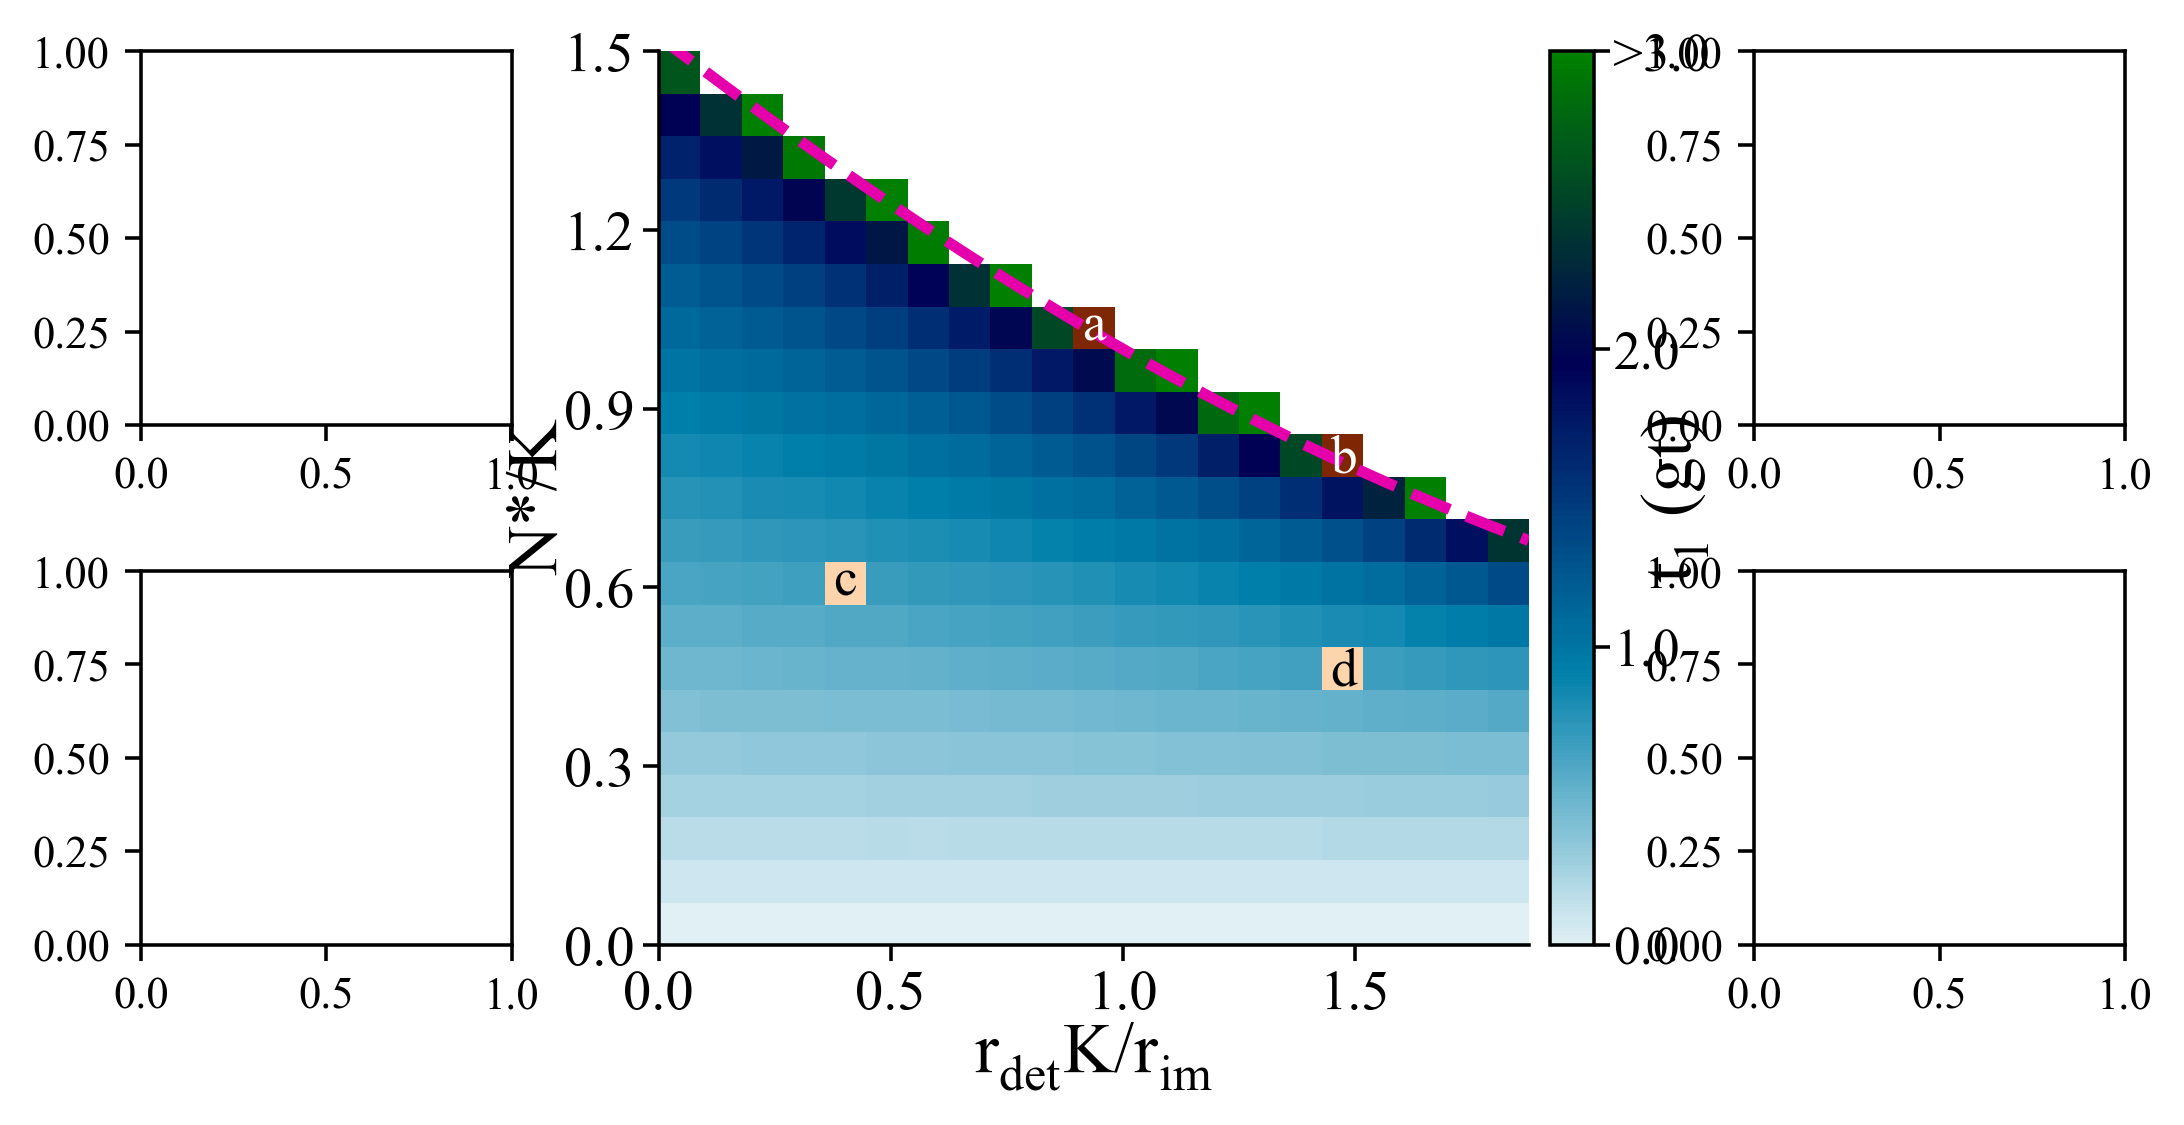

In [31]:
plotPhaseDiagramAndHistograms(histogram_param_pairs, histogram_param_pair_labels)

In [29]:
param_data.sort_values(by=['tN_adjusted'], ascending=False)

,n_thresh,det_ratio,time_to_n,time_elapsed,time_to_n_raw,time_to_n_stDev,coeff_variation,tN_adjusted,r_det_K_r_imm_ratio
247,0.825,1.200,31.401652,8.640000e+09,378.33316,22.822461,0.726792,31.401652,1.50000
304,1.050,0.750,28.977504,7.200000e+09,349.12656,26.207379,0.904404,28.977504,0.93750
362,1.275,0.375,10.575860,9.000000e+09,127.42000,5.845100,0.552683,10.575860,0.46875
401,1.425,0.150,6.156359,9.000000e+09,74.17300,2.509728,0.407664,6.156359,0.18750
266,0.900,1.050,5.451898,7.200009e+08,65.68552,18.871144,3.461390,5.451898,1.31250
...,...,...,...,...,...,...,...,...,...
436,1.500,1.200,0.000000,1.000063e+03,0.00000,0.000000,NaN,NaN,1.50000
437,1.500,1.275,0.000000,1.000064e+03,0.00000,0.000000,NaN,NaN,1.59375
438,1.500,1.350,0.000000,1.000073e+03,0.00000,0.000000,NaN,NaN,1.68750
439,1.500,1.425,0.000000,1.000073e+03,0.00000,0.000000,NaN,NaN,1.78125
